In [ ]:
import pandas as pd
import numpy

In [ ]:
names = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv("/content/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


In [ ]:
for name in categorical:
    df[name] = df[name].astype('category')

In [ ]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [ ]:
full_spans = get_spans(df, df.index)
full_spans

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

In [ ]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [ ]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [ ]:
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [ ]:
len(finished_partitions)

500

In [ ]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [ ]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        unique, counts = numpy.unique(str(df[column]).split(), return_counts=True)
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [ ]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [ ]:
rects[:10]

[((17.0, 7.0), (18.0, 9.0)),
 ((18.0, 7.0), (20.0, 9.0)),
 ((21.0, 10.0), (22.0, 11.0)),
 ((25.0, 10.0), (27.0, 11.0)),
 ((37.0, 9.0), (39.0, 10.0)),
 ((37.0, 10.0), (38.0, 13.0)),
 ((41.0, 10.0), (43.0, 13.0)),
 ((39.0, 13.0), (41.0, 16.0)),
 ((46.0, 10.0), (48.0, 13.0)),
 ((46.0, 13.0), (48.0, 16.0))]

In [ ]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

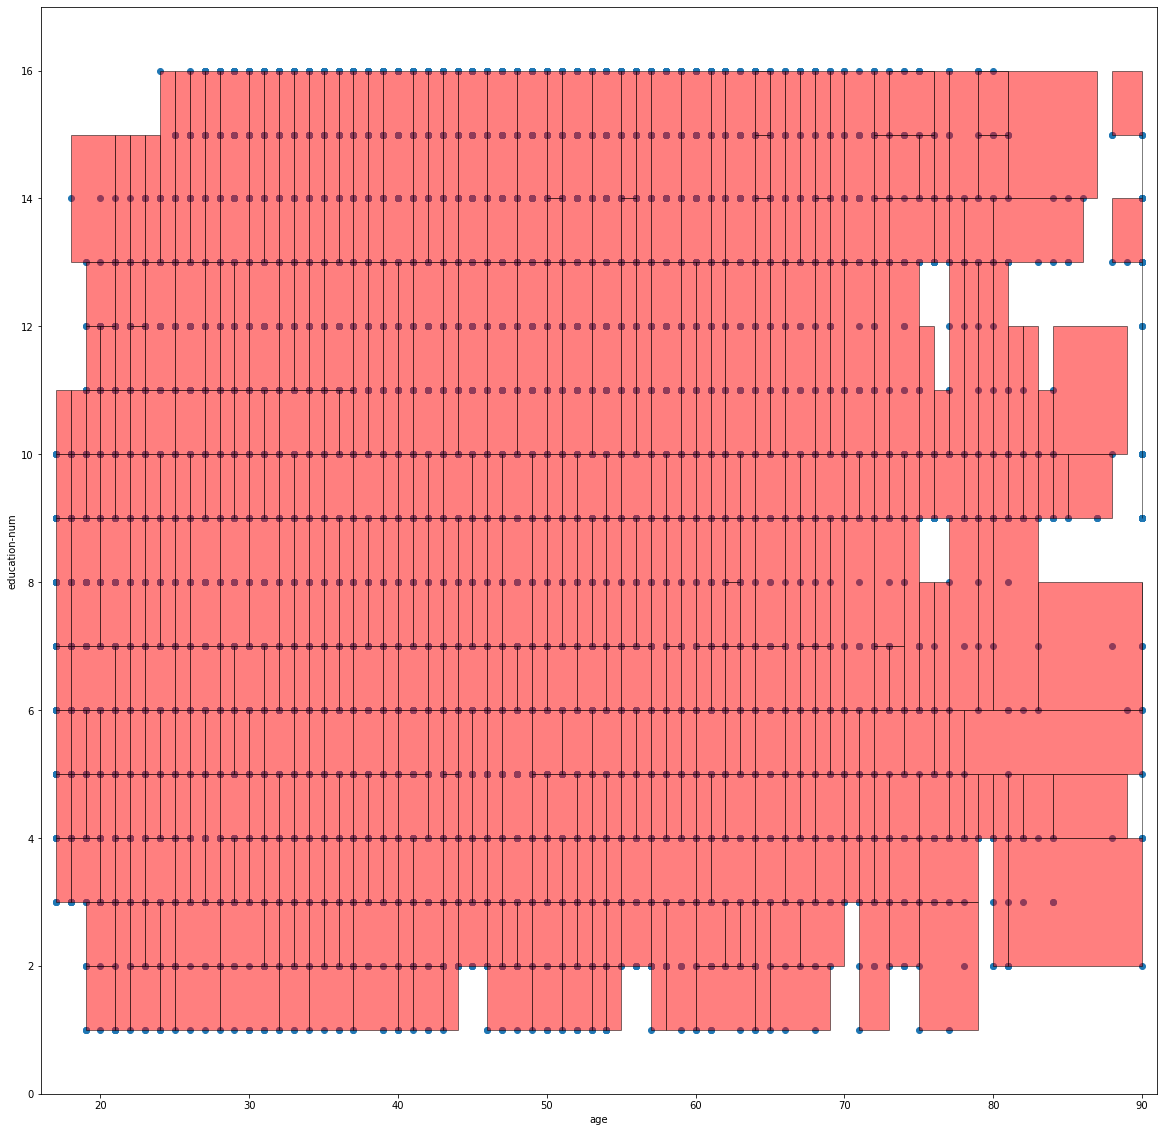

In [ ]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [ ]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [ ]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [ ]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [ ]:
print(dfn)

                     age        education-num income  count
0                 [17.0]  [7.200598802395209]  <=50k    334
1    [18.22787610619469]  [7.283185840707965]  <=50k    451
2    [18.22787610619469]  [7.283185840707965]   >50k      1
3                 [21.0]               [10.0]  <=50k    568
4                 [21.0]               [10.0]   >50k      2
..                   ...                  ...    ...    ...
817              [79.25]               [16.0]   >50k      2
818               [90.0]               [14.0]  <=50k      2
819               [90.0]               [14.0]   >50k      3
820               [89.2]               [15.0]  <=50k      3
821               [89.2]               [15.0]   >50k      2

[822 rows x 4 columns]


L diversity


In [ ]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(df, partition, sensitive_column) >= l

In [ ]:
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [ ]:
len(finished_l_diverse_partitions)

309

In [ ]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

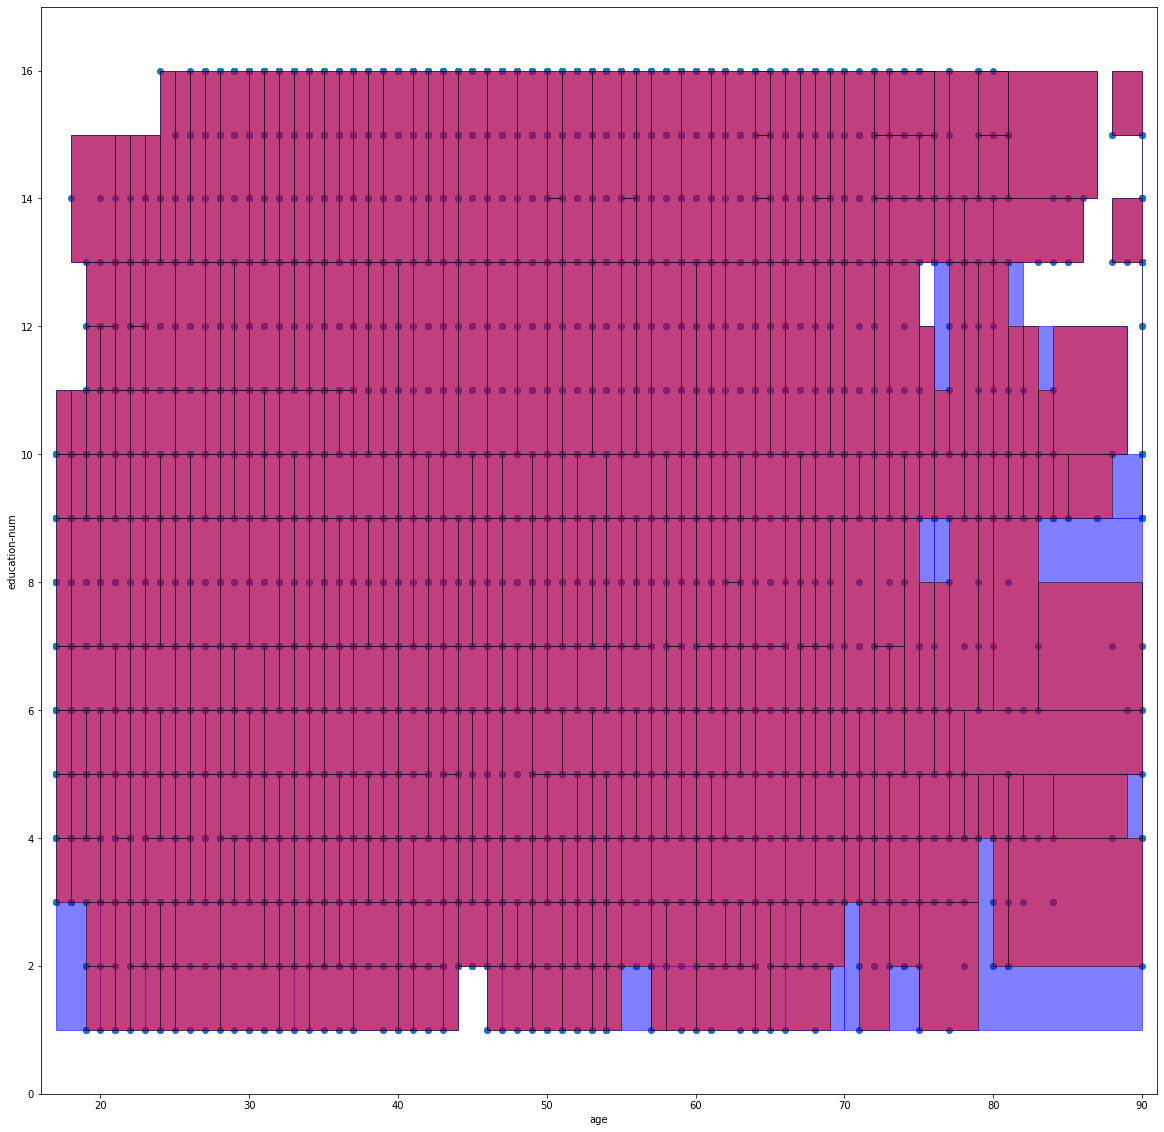

In [ ]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [ ]:
# again we build an anonymized dataset from the l-diverse partitions
dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...


In [ ]:
print(dfl)

                      age        education-num income  count
0    [17.706106870229007]  [7.248091603053435]  <=50k    785
1    [17.706106870229007]  [7.248091603053435]   >50k      1
2    [20.080607476635514]                [9.0]  <=50k   1707
3    [20.080607476635514]                [9.0]   >50k      5
4    [19.320276497695854]               [10.0]  <=50k   1301
..                    ...                  ...    ...    ...
613               [79.25]               [16.0]   >50k      2
614                [90.0]               [14.0]  <=50k      2
615                [90.0]               [14.0]   >50k      3
616                [89.2]               [15.0]  <=50k      3
617                [89.2]               [15.0]   >50k      2

[618 rows x 4 columns]


Pseudonimyzation

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
names = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

df = pd.read_csv("/content/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');

/usr/local/lib/python3.8/dist-packages/pandas/io/parsers/readers.py:586: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return _read(filepath_or_buffer, kwds)


In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50k
2,38,Private,215646,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50k
3,53,Private,234721,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50k
4,28,Private,338409,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50k


In [ ]:
num_intervals =
pseudonym_length = 8

In [ ]:
for i in range(num_intervals):
    # Generate a new set of pseudonyms
    pseudonyms = pd.Series([''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz0123456789'), pseudonym_length)) for j in range(len(df))])
    # Add the pseudonyms to the dataset
    df[f'pseudonym_{i}'] = pseudonyms

In [ ]:
print(df)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors           13.0   
1       50  Self-emp-not-inc   83311  Bachelors           13.0   
2       38           Private  215646    HS-grad            9.0   
3       53           Private  234721       11th            7.0   
4       28           Private  338409  Bachelors           13.0   
...    ...               ...     ...        ...            ...   
40250   39           Private  215419  Bachelors           13.0   
40251   64                 ?  321403    HS-grad            9.0   
40252   38           Private  374983  Bachelors           13.0   
40253   44           Private   83891  Bachelors           13.0   
40254   35      Self-emp-inc  182148  Bachelors           13.0   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

Pseudonimyzation on quasi identifiers

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
names = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)
df = pd.read_csv("/content/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');

/usr/local/lib/python3.8/dist-packages/pandas/io/parsers/readers.py:586: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return _read(filepath_or_buffer, kwds)


In [ ]:
pseudonym_length=8

In [ ]:
print(df)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors           13.0   
1       50  Self-emp-not-inc   83311  Bachelors           13.0   
2       38           Private  215646    HS-grad            9.0   
3       53           Private  234721       11th            7.0   
4       28           Private  338409  Bachelors           13.0   
...    ...               ...     ...        ...            ...   
40250   39           Private  215419  Bachelors           13.0   
40251   64                 ?  321403    HS-grad            9.0   
40252   38           Private  374983  Bachelors           13.0   
40253   44           Private   83891  Bachelors           13.0   
40254   35      Self-emp-inc  182148  Bachelors           13.0   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

In [ ]:
alphabet = list('abcdefghijklmnopqrstuvwxyz0123456789')

# Generating a new pseudonym for each age value
age_pseudonyms = {}
for age in df['age'].unique():
    age_pseudonyms[age] = ''.join(np.random.choice(alphabet, pseudonym_length))

df['age'] = df['age'].apply(lambda x: age_pseudonyms[x])

sex={}
for s in df['sex'].unique():
    sex[s]=''.join(np.random.choice(alphabet, pseudonym_length))

df['sex']=df['sex'].apply(lambda x:sex[x])

education={}

for e in df['education'].unique():
    education[e]=''.join(np.random.choice(alphabet, pseudonym_length))

df['education']=df['education'].apply(lambda x:education[x])

In [ ]:
print(df)

            age         workclass  fnlwgt education  education-num  \
0      vjv6s3wl         State-gov   77516  0p1k3n85           13.0   
1      wrbn2kqf  Self-emp-not-inc   83311  0p1k3n85           13.0   
2      ulvw1so2           Private  215646  pnzrk74y            9.0   
3      izjk37yw           Private  234721  vudo8156            7.0   
4      lsf2kdlh           Private  338409  0p1k3n85           13.0   
...         ...               ...     ...       ...            ...   
40250  vjv6s3wl           Private  215419  0p1k3n85           13.0   
40251  sio6kbzz                 ?  321403  pnzrk74y            9.0   
40252  ulvw1so2           Private  374983  0p1k3n85           13.0   
40253  k56p3a2i           Private   83891  0p1k3n85           13.0   
40254  r2b0ycw9      Self-emp-inc  182148  0p1k3n85           13.0   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Ex

In [ ]:
df.to_csv('pseudonymized_adult.csv', index=False)

K-anonymization with pseudonymization

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

names = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)
df = pd.read_csv("/content/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');

num_intervals = 10
pseudonym_length = 8

for i in range(num_intervals):
    pseudonyms = pd.Series([''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz0123456789'), pseudonym_length)) for j in range(len(df))])
    df[f'pseudonym_{i}'] = pseudonyms

train, test = train_test_split(df, test_size=0.3)

# Perform k-anonymization on the training set
k = 5
sensitive_attributes = ['fnlwgt']
quasi_identifiers = ['age', 'sex', 'education']

qi_counts = train[quasi_identifiers].groupby(quasi_identifiers).size().reset_index(name='count')
qi_dict = qi_counts.set_index(quasi_identifiers).to_dict()['count']

# Replace quasi-identifiers with their frequencies in the training set
train['qi_freq'] = [qi_dict[tuple(row)] for _, row in train[quasi_identifiers].iterrows()]

# Find the groups of records that satisfy the k-anonymity requirement
groups = train.groupby(quasi_identifiers).filter(lambda group: group['qi_freq'].count() >= k)

for sa in sensitive_attributes:
    groups[sa] = groups[sa].apply(lambda x: round(x, -3))

train.update(groups)

train = train.drop(columns=['qi_freq'])

# test = pd.merge(test, train[[*quasi_identifiers] + *[f'pseudonym_{i}' for i in range(num_intervals)]], on=quasi_identifiers)
test = pd.merge(test, train[[*quasi_identifiers, *[f'pseudonym_{i}' for i in range(num_intervals)]]], left_on=quasi_identifiers, right_on=quasi_identifiers)
# Export the pseudonymized and k-anonymized dataset
train.to_csv('employee_train_pseudonymized_k_anonymized.csv', index=False)
test.to_csv('employee_test_pseudonymized_k_anonymized.csv', index=False)

new york city trip data 2016 pseudonymization

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:/Users/shant/Desktop/K-Anonymity-master/datasets/Green_Taxi_Trip_Data.csv')

pseudonym_length = 8

alphabet = list('abcdefghijklmnopqrstuvwxyz0123456789')

pickup_pseudonyms = {}

for lat, lon in df[['Pickup_latitude', 'Pickup_longitude']].drop_duplicates().values:
    pickup_pseudonyms[(lat, lon)] = ''.join(np.random.choice(alphabet, pseudonym_length))

df['Pickup_latitude'] = df['Pickup_latitude'].astype('object')
df['Pickup_latitude'] = df['Pickup_latitude'].fillna(-1)
df['Pickup_latitude'] = df['Pickup_latitude'].apply(lambda x: pickup_pseudonyms[(df.loc[x.index, 'Pickup_latitude'].values[0], df.loc[x.index, 'Pickup_longitude'].values[0])])
df['Pickup_longitude'] = df['Pickup_longitude'].astype('object')
df['Pickup_longitude'] = df['Pickup_longitude'].fillna(-1)
df['Pickup_longitude'] = df['Pickup_longitude'].apply(lambda x: pickup_pseudonyms[(df.loc[x.index, 'Pickup_latitude'].values[0], df.loc[x.index, 'Pickup_longitude'].values[0])])

dropoff_pseudonyms = {}
for lat, lon in df[['Dropoff_latitude', 'Dropoff_longitude']].drop_duplicates().values:
    dropoff_pseudonyms[(lat, lon)] = ''.join(np.random.choice(alphabet, pseudonym_length))

df['Dropoff_latitude'] = df['Dropoff_latitude'].astype('object')
df['Dropoff_latitude'] = df['Dropoff_latitude'].fillna(-1)
df['Dropoff_latitude'] = df['Dropoff_latitude'].apply(lambda x: dropoff_pseudonyms[(df.loc[x.index, 'Dropoff_latitude'].values[0], df.loc[x.index, 'Dropoff_longitude'].values[0])])
df['Dropoff_longitude'] = df['Dropoff_longitude'].astype('object')
df['Dropoff_longitude'] = df['Dropoff_longitude'].fillna(-1)
df['Dropoff_longitude'] = df['Dropoff_longitude'].apply(lambda x: dropoff_pseudonyms[(df.loc[x.index, 'Dropoff_latitude'].values[0], df.loc[x.index, 'Dropoff_longitude'].values[0])])

passenger_count_pseudonyms = {}
for passenger_count in df['Passenger_count'].unique():
    passenger_count_pseudonyms[passenger_count] = ''.join(np.random.choice(alphabet, pseudonym_length))

df['Passenger_count'] = df['Passenger_count'].apply(lambda x: passenger_count_pseudonyms[x])

trip_distance_pseudonyms = {}
for trip_distance in df['Trip_distance'].unique():
    trip_distance_pseudonyms[trip_distance] = ''.join(np.random.choice(alphabet, pseudonym_length))

df['Trip_distance'] = df['Trip_distance'].apply(lambda x: trip_distance_pseudonyms[x])

fare_amount_pseudonyms = {}
for fare_amount in df['Fare_amount'].unique():
    fare_amount_pseudonyms[fare_amount] = ''.join(np.random.choice(alphabet, pseudonym_length))

df['Fare_amount'] = df['Fare_amount'].apply(lambda x: fare_amount_pseudonyms[x])

df.to_csv('pseudonymized_green_taxi.csv',index=False)


k-anonymization + pseudonymization

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:/Users/shant/Desktop/K-Anonymity-master/datasets/bks tripdata/bks_tripdata_v2.csv')

# Perform k-anonymization
k = 5  # specify the desired k value
df = df.groupby(['start_lat', 'start_lng', 'end_lat', 'end_lng']).apply(lambda x: x.sample(min(k, len(x)))).reset_index(drop=True)

pseudonym_length = 8

alphabet = list('abcdefghijklmnopqrstuvwxyz0123456789')

df['start_lat'] = df['start_lat'].fillna(-1)
df['start_lng'] = df['start_lng'].fillna(-1)
df['end_lat'] = df['end_lat'].fillna(-1)
df['end_lng'] = df['end_lng'].fillna(-1)

# Pseudonymize start_lat and end_lat columns
lat_pseudonyms = {}
for lat in df['start_lat'].unique():
    lat_pseudonyms[lat] = ''.join(np.random.choice(alphabet, pseudonym_length))
for lat in df['end_lat'].unique():
    lat_pseudonyms[lat] = ''.join(np.random.choice(alphabet, pseudonym_length))
df['start_lat'] = df['start_lat'].apply(lambda x: lat_pseudonyms[x])
df['end_lat'] = df['end_lat'].apply(lambda x: lat_pseudonyms[x])

# Pseudonymize start_lng and end_lng columns
lng_pseudonyms = {}
for lng in df['start_lng'].unique():
    lng_pseudonyms[lng] = ''.join(np.random.choice(alphabet, pseudonym_length))
for lng in df['end_lng'].unique():
    lng_pseudonyms[lng] = ''.join(np.random.choice(alphabet, pseudonym_length))
df['start_lng'] = df['start_lng'].apply(lambda x: lng_pseudonyms[x])
df['end_lng'] = df['end_lng'].apply(lambda x: lng_pseudonyms[x])

# Pseudonymize start_station_id and end_station_id columns
start_stations = {}
for station_id in df['start_station_id'].unique():
    start_stations[station_id] = df['start_station_name']

end_stations = {}
for end_id in df['end_station_id'].unique():
    end_stations[end_id] = df['end_station_name']

df=df.drop('start_station_name',axis=1)

df=df.drop('end_station_name',axis=1)

member_pseudonym={}
for member in df['member_casual'].unique():
    member_pseudonym[member]=''.join(np.random.choice(alphabet, pseudonym_length))
df['member_casual'] = df['member_casual'].apply(lambda x: member_pseudonym[x])

# Save pseudonymized data to CSV
df.to_csv('k-pseudonymized_data.csv', index=False)


l-diversity and pseudonymization

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

# Load the dataset
df = pd.read_csv('C:/Users/shant/Desktop/K-Anonymity-master/datasets/bks tripdata/bks_tripdata_v2.csv')

# Specify the desired l value for l-diversity
l = 3

# Define a function to perform l-diversity on a column
def l_diversity(column, l):
    counts = Counter(column)
    for i in range(len(column)):
        if counts[column[i]] < l:
            # Replace the value with a generalization or pseudonym
            column[i] = 'Unknown'
    return column

# Perform l-diversity on sensitive columns
df['age'] = l_diversity(df['age'], l)
df['gender'] = l_diversity(df['gender'], l)

pseudonym_length = 8

alphabet = list('abcdefghijklmnopqrstuvwxyz0123456789')

df['start_lat'] = df['start_lat'].fillna(-1)
df['start_lng'] = df['start_lng'].fillna(-1)
df['end_lat'] = df['end_lat'].fillna(-1)
df['end_lng'] = df['end_lng'].fillna(-1)

# Pseudonymize start_lat and end_lat columns
lat_pseudonyms = {}
for lat in df['start_lat'].unique():
    lat_pseudonyms[lat] = ''.join(np.random.choice(alphabet, pseudonym_length))
for lat in df['end_lat'].unique():
    lat_pseudonyms[lat] = ''.join(np.random.choice(alphabet, pseudonym_length))
df['start_lat'] = df['start_lat'].apply(lambda x: lat_pseudonyms[x])
df['end_lat'] = df['end_lat'].apply(lambda x: lat_pseudonyms[x])

# Pseudonymize start_lng and end_lng columns
lng_pseudonyms = {}
for lng in df['start_lng'].unique():
    lng_pseudonyms[lng] = ''.join(np.random.choice(alphabet, pseudonym_length))
for lng in df['end_lng'].unique():
    lng_pseudonyms[lng] = ''.join(np.random.choice(alphabet, pseudonym_length))
df['start_lng'] = df['start_lng'].apply(lambda x: lng_pseudonyms[x])
df['end_lng'] = df['end_lng'].apply(lambda x: lng_pseudonyms[x])

# Pseudonymize start_station_id and end_station_id columns
start_stations = {}
for station_id in df['start_station_id'].unique():
    start_stations[station_id] = df['start_station_name']

end_stations = {}
for end_id in df['end_station_id'].unique():
    end_stations[end_id] = df['end_station_name']

df=df.drop('start_station_name',axis=1)

df=df.drop('end_station_name',axis=1)

member_pseudonym={}
for member in df['member_casual'].unique():
    member_pseudonym[member]=''.join(np.random.choice(alphabet, pseudonym_length))
df['member_casual'] = df['member_casual'].apply(lambda x: member_pseudonym[x])

# Save pseudonymized data to CSV
df.to_csv('l-pseudonymized_data.csv', index=False)


Distance correlation


In [ ]:
import numpy as np

def pairwise_distance_matrix(X):
    n_samples = X.shape[0]
    D = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            D[i, j] = np.linalg.norm(X[i] - X[j])
            D[j, i] = D[i, j]
    return D

def distance_correlation(X, Y):
    if X.shape[0] != Y.shape[0]:
        raise ValueError("Input datasets must have the same number of rows")

    n = X.shape[0]
    a = pairwise_distance_matrix(X)
    b = pairwise_distance_matrix(Y)
    aa = np.mean(a, axis=1) - np.mean(a, axis=0) + np.mean(a)
    bb = np.mean(b, axis=1) - np.mean(b, axis=0) + np.mean(b)
    d_cov2_y = np.sum(a * b) / (n * n)
    d_cov2_x = np.sum(a * a) / (n * n)
    d_cov2_yy = np.sum(b * b) / (n * n)

    dcor = d_cov2_y / np.sqrt(d_cov2_x * d_cov2_yy)
    return dcor
